# Comparativa de Modelos PyTorch y Quantized sobre CIFAR-10 para Edge/Federated Learning

Este notebook explora el entrenamiento, validación y comparación de modelos deep learning (MLP, CNN, MobileNetV3, EfficientNet-lite0) sobre el dataset CIFAR-10. El objetivo es analizar la portabilidad, reproducibilidad y eficiencia de estos modelos en GPU y CPU, con especial foco en escenarios de edge computing y federated learning.

**Aspectos clave:**
 - Entrenamiento y evaluación reproducible de modelos en GPU y CPU.
 - Comparación de accuracy, tiempos de inferencia y tamaño de modelo.
 - Reflexión sobre portabilidad y eficiencia en IA distribuida y federada.

In [2]:
# Recarga automática de módulos para desarrollo interactivo
%load_ext autoreload
%autoreload 2

import os
import pickle

# Importación de librerías y utilidades
import torch
from models.cnn import CNN
from models.efficientnet_lite0 import EfficientNetLite0
from models.mlp import MLP
from models.mobilenetv3 import MobileNetV3

from utils.data_utils import get_cifar10_dataloaders
from utils.device_utils import get_available_devices, get_eval_devices, print_available_devices, select_main_device, get_device_fullname
from utils.export_utils import save_model, load_model
from utils.metrics_utils import compute_confusion_matrix, plot_confusion_matrix, compute_classification_metrics
from utils.train_utils import train_model, evaluate_model
from utils.viz_utils import plot_loss_accuracy_curves, show_comparative_table, plot_bar_comparison
import torch.nn.init as init

def initialize_weights_randomly(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d) or isinstance(m, torch.nn.BatchNorm1d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

## Carga y preprocesamiento del dataset CIFAR-10

Utilizamos las utilidades del proyecto para descargar y preparar los DataLoaders de entrenamiento y test, con aumentación de datos estándar para imágenes pequeñas.


In [3]:
# Cargar CIFAR-10
batch_size = 128
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size, data_augmentation=True)
num_classes = 10
input_shape = (3, 32, 32)


Files already downloaded and verified
Files already downloaded and verified


## Entrenamiento y carga de modelos

Entrenamos (o cargamos si ya existen) los modelos MLP, CNN, MobileNetV3 y EfficientNet-lite0. Los modelos y sus historiales de entrenamiento se guardan en `/models_saved` para reproducibilidad y comparación.


In [4]:
# Configuración de dispositivos
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from pathlib import Path

model_dir = Path(os.getcwd()).parent / 'models_saved'
model_dir.mkdir(exist_ok=True)

model_configs = {
    'MLP': {
        'class': MLP,
        'args': {'input_size': 32 * 32 * 3, 'num_classes': num_classes},
        'file': 'mlp_cifar10.pt',
        'hist': 'mlp_cifar10_hist.pkl'
    },
    'CNN': {
        'class': CNN,
        'args': {'input_channels': 3, 'num_classes': num_classes, 'input_size': 32},
        'file': 'cnn_cifar10.pt',
        'hist': 'cnn_cifar10_hist.pkl'
    },
    'MobileNetV3': {
        'class': MobileNetV3,
        'args': {'num_classes': num_classes},
        'file': 'mobilenetv3_cifar10.pt',
        'hist': 'mobilenetv3_cifar10_hist.pkl'
    },
    'EfficientNetLite0': {
        'class': EfficientNetLite0,
        'args': {'num_classes': num_classes},
        'file': 'efficientnetlite0_cifar10.pt',
        'hist': 'efficientnetlite0_cifar10_hist.pkl'
    }
}

# Mostrar dispositivos disponibles y seleccionar el principal para entrenamiento
print_available_devices()
available_devices = get_available_devices()
device, device_name, device_type, device_id = select_main_device(available_devices)
print(f"Entrenamiento se va a realizar en {device_name} [{device_type}]")

histories = {}
models = {}
for name, cfg in model_configs.items():
    model = cfg['class'](**cfg['args'])
    initialize_weights_randomly(model)
    model_file = cfg['file']
    hist_path = cfg['hist']
    # Intentar cargar modelo y su historial
    try:
        load_model(model, model_file, map_location=device.type)
        with open(model_dir / hist_path, 'rb') as f:
            history = pickle.load(f)
        print(f"Modelo {name} cargado de disco.")
    except Exception:
        print(f"Entrenando modelo {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        history = train_model(model, optimizer, train_loader, device, num_epochs=20)
        save_model(model, model_file, optimizer=None)
        with open(model_dir / hist_path, 'wb') as f:
            pickle.dump(history, f)
    histories[name] = history
    models[name] = model


Available devices for backend 'pytorch':
- Intel(R) Core(TM) Ultra 9 185H [CPU]
- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]
Entrenamiento se va a realizar en NVIDIA GeForce RTX 4080 Laptop GPU [GPU]
Modelo MLP cargado de disco.
Modelo CNN cargado de disco.
Modelo MobileNetV3 cargado de disco.
Modelo EfficientNetLite0 cargado de disco.


## Evaluación de modelos en GPU y CPU

Se evalúan todos los modelos en GPU y CPU, registrando accuracy, tiempos de inferencia y tamaño de modelo. Esto permite comparar portabilidad y reproducibilidad entre dispositivos.


In [5]:
import platform

# Mostrar dispositivos disponibles (nombre completo y tipo)
print_available_devices()
available_devices = get_available_devices()

# Selección de dispositivos para evaluación (profesional y coherente)
eval_devices = get_eval_devices(available_devices)

results = []
for dev in eval_devices:
    device_fullname = get_device_fullname(dev, eval_devices)
    dev_type = dev.type if hasattr(dev, 'type') else str(dev)
    print(f"Evaluando modelos en {device_fullname} [{dev_type}]")
    for name, model in {**models}.items():
        eval_dev = dev
        metrics = evaluate_model(model, test_loader, eval_dev, verbose=False)
        model_path = model_configs.get(name.replace('_quant', ''), {}).get('file', f'{name}.pt')
        model_file = model_dir / model_path if (model_dir / model_path).exists() else None
        size = os.path.getsize(model_file) if model_file else None
        result = {
            'Modelo': name,
            'Device': dev_type,
            'Device_name': str(dev),
            'Device_fullname': device_fullname,
            'Accuracy': metrics['accuracy'],
            'Loss': metrics['loss'],
            'Tiempo_inferencia_total': metrics['total_time'],
            'Tiempo_inferencia_promedio': metrics['avg_inference_time'],
            'Tamaño_bytes': size
        }
        results.append(result)
        print(f"  -> {name}: Accuracy={result['Accuracy']:.4f}, Loss={result['Loss']:.4f}, "
              f"Tiempo total={result['Tiempo_inferencia_total']:.2f}s, "
              f"Tiempo medio={result['Tiempo_inferencia_promedio']*1000:.2f}ms, "
              f"Tamaño={result['Tamaño_bytes']} bytes")


Available devices for backend 'pytorch':
- Intel(R) Core(TM) Ultra 9 185H [CPU]
- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]
Evaluando modelos en Intel(R) Core(TM) Ultra 9 185H [cpu]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Tiempo total=7.66s, Tiempo medio=0.77ms, Tamaño=3286256 bytes
  -> CNN: Accuracy=0.7735, Loss=0.6702, Tiempo total=8.87s, Tiempo medio=0.89ms, Tamaño=2188344 bytes
  -> MobileNetV3: Accuracy=0.7659, Loss=0.6759, Tiempo total=16.85s, Tiempo medio=1.69ms, Tamaño=6251626 bytes
  -> EfficientNetLite0: Accuracy=0.8307, Loss=0.4978, Tiempo total=103.29s, Tiempo medio=10.33ms, Tamaño=16390458 bytes
Evaluando modelos en NVIDIA GeForce RTX 4080 Laptop GPU [cuda]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Tiempo total=7.36s, Tiempo medio=0.74ms, Tamaño=3286256 bytes
  -> CNN: Accuracy=0.7736, Loss=0.6702, Tiempo total=7.19s, Tiempo medio=0.72ms, Tamaño=2188344 bytes
  -> MobileNetV3: Accuracy=0.7660, Loss=0.6759, Tiempo total=7.60s, Tiempo medio=0.76ms, Tamaño=6251626 bytes


## Visualización de resultados y análisis comparativo

Se grafican las curvas de pérdida y accuracy, y se muestran tablas y gráficas de barras para comparar accuracy, tiempos y tamaños entre modelos y variantes.


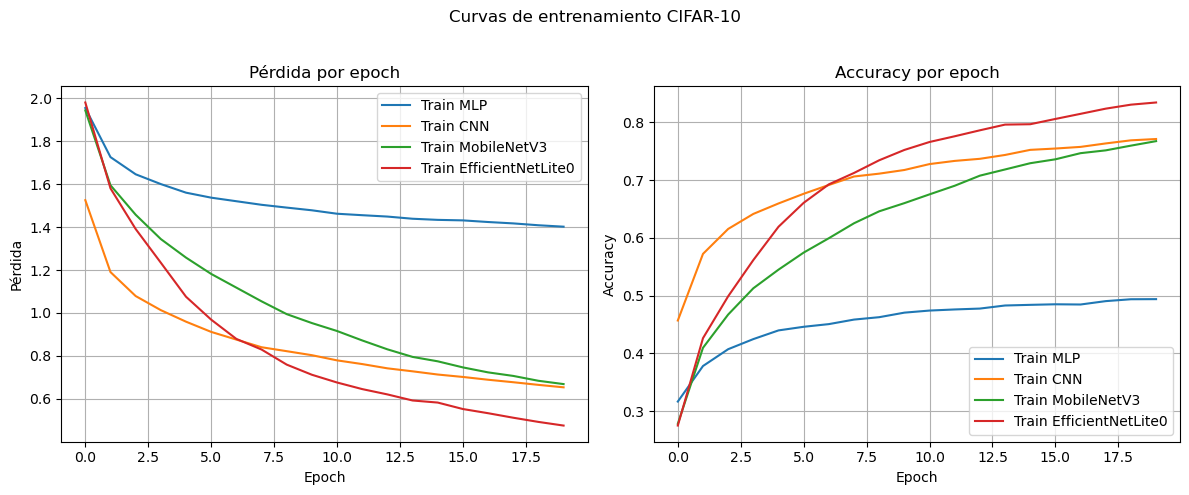

                                                    Accuracy      Loss  \
MLP-Intel(R) Core(TM) Ultra 9 185H                    0.4695  1.491604   
CNN-Intel(R) Core(TM) Ultra 9 185H                    0.7735  0.670154   
MobileNetV3-Intel(R) Core(TM) Ultra 9 185H            0.7659  0.675892   
EfficientNetLite0-Intel(R) Core(TM) Ultra 9 185H      0.8307  0.497760   
MLP-NVIDIA GeForce RTX 4080 Laptop GPU                0.4695  1.491604   
CNN-NVIDIA GeForce RTX 4080 Laptop GPU                0.7736  0.670154   
MobileNetV3-NVIDIA GeForce RTX 4080 Laptop GPU        0.7660  0.675882   
EfficientNetLite0-NVIDIA GeForce RTX 4080 Lapto...    0.8307  0.497712   

                                                    Tiempo_inferencia_total  \
MLP-Intel(R) Core(TM) Ultra 9 185H                                 7.659693   
CNN-Intel(R) Core(TM) Ultra 9 185H                                 8.870343   
MobileNetV3-Intel(R) Core(TM) Ultra 9 185H                        16.852636   
EfficientNetLite0

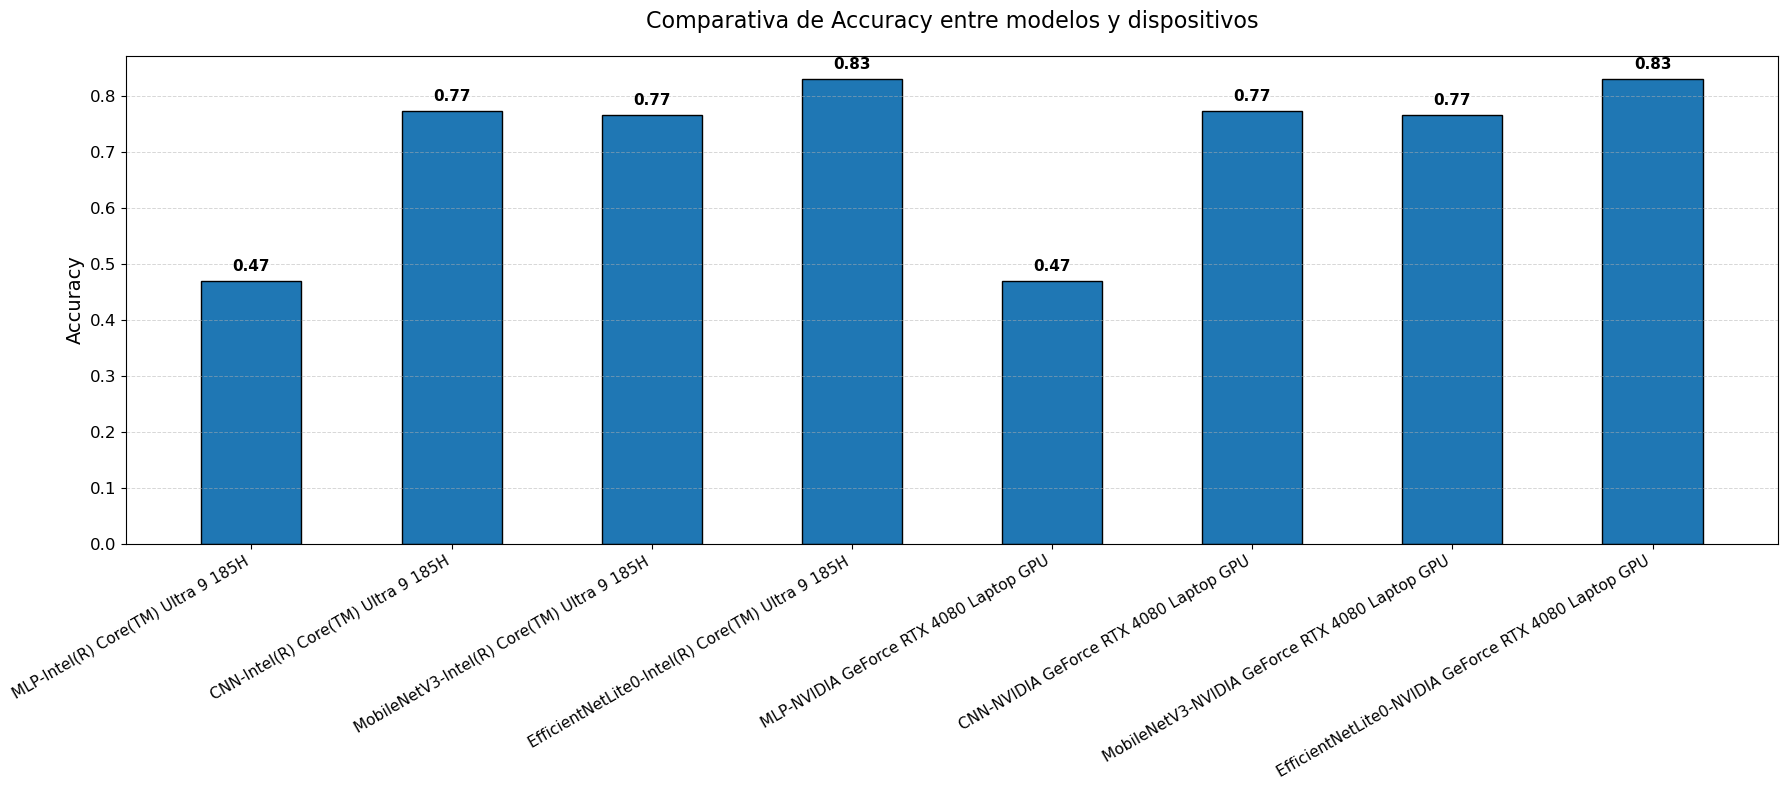

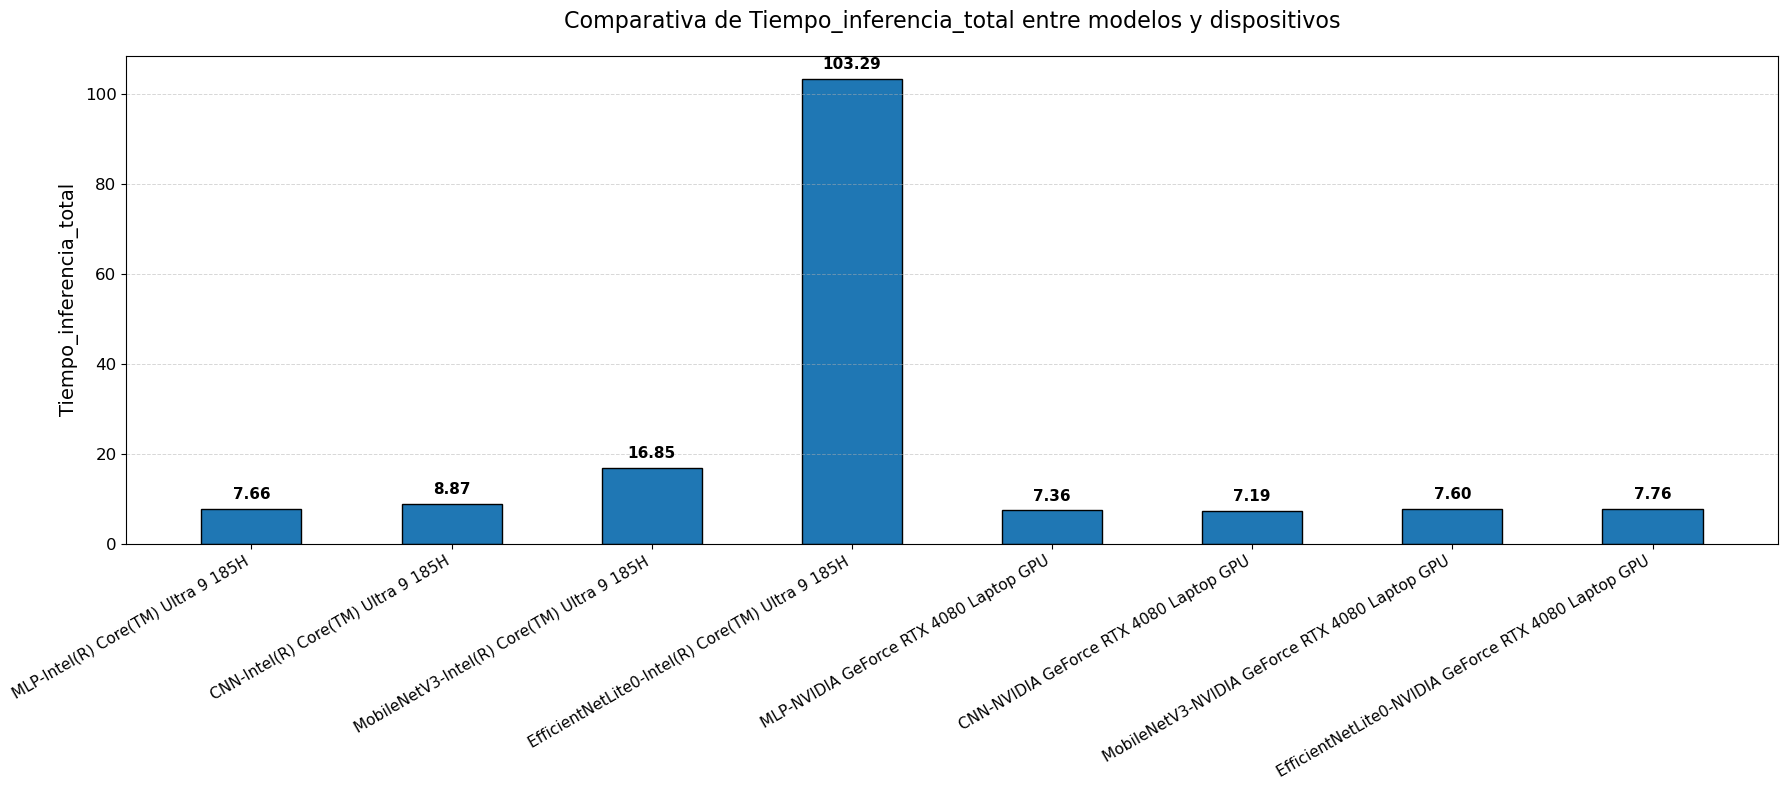

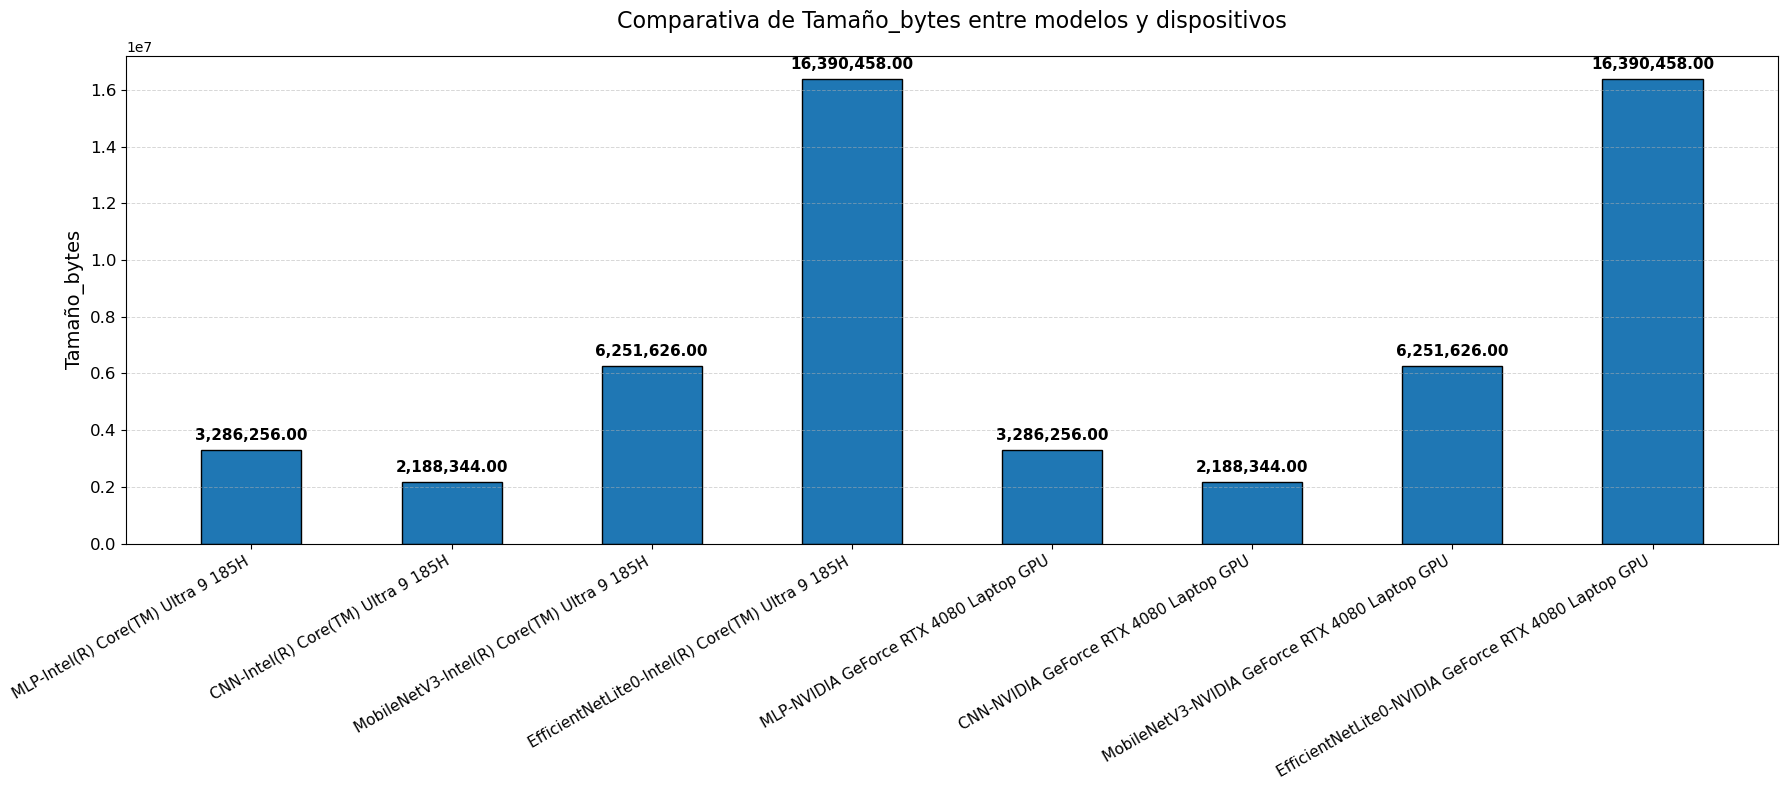

In [6]:
# Curvas de entrenamiento
plot_loss_accuracy_curves([histories[k] for k in histories], labels=list(histories.keys()),
                          title="Curvas de entrenamiento CIFAR-10")

# Tabla comparativa
import pandas as pd

df_results = pd.DataFrame(results)
show_comparative_table(results, model_names=[r['Modelo'] + "-" + r['Device_fullname'] for r in results],
                       columns=['Accuracy', 'Loss', 'Tiempo_inferencia_total', 'Tamaño_bytes'])

# Gráficas de barras
for metric in ['Accuracy', 'Tiempo_inferencia_total', 'Tamaño_bytes']:
    plot_bar_comparison(
        values=df_results[metric],
        labels=df_results['Modelo'] + "-" + df_results['Device_fullname'],
        ylabel=metric,
        title=f"Comparativa de {metric} entre modelos y dispositivos"
    )


## Métricas avanzadas y matriz de confusión

En esta sección se calculan y visualizan métricas avanzadas (F1, precisión, recall) y la matriz de confusión
para el mejor modelo normal, usando el conjunto de test de CIFAR-10.

Matriz de confusión - Modelo normal


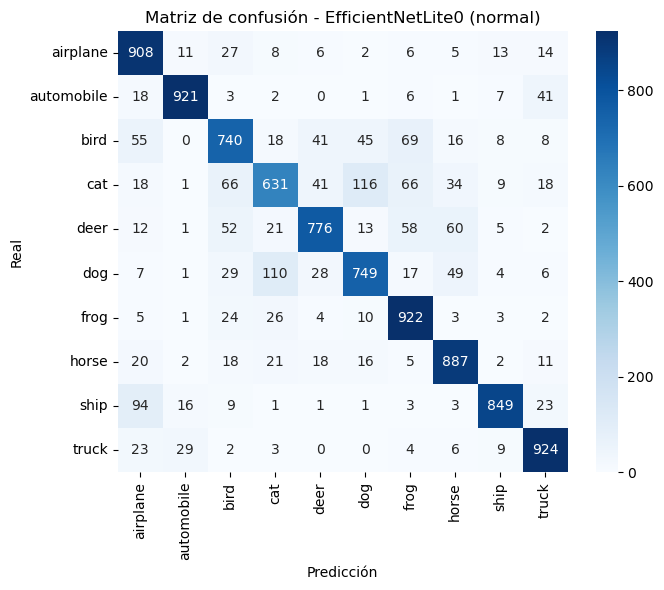

Métricas globales - Modelo normal


,Accuracy,F1 (macro),Precision (macro),Recall (macro)
0,0.8307,0.829003,0.831295,0.8307


Métricas por clase - Modelo normal


,F1,Precision,Recall
airplane,0.840741,0.782759,0.908
automobile,0.928896,0.936928,0.921
bird,0.751269,0.762887,0.740
cat,0.685497,0.750297,0.631
deer,0.810444,0.848087,0.776
dog,0.767025,0.785939,0.749
frog,0.855288,0.797578,0.922
horse,0.859496,0.833647,0.887
ship,0.889471,0.933993,0.849
truck,0.901903,0.880839,0.924


In [7]:
# Definir nombres de clases CIFAR-10
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Elegir modelos a analizar (puedes cambiar por otros si lo deseas)
best_normal = models['EfficientNetLite0'] if 'EfficientNetLite0' in models else list(models.values())[0]


# Obtener predicciones y etiquetas reales para ambos modelos
def get_preds_and_labels(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
    return y_true, y_pred


# Normal
normal_y_true, normal_y_pred = get_preds_and_labels(best_normal, test_loader, device)

# Calcular y mostrar matriz de confusión
cm_normal = compute_confusion_matrix(normal_y_true, normal_y_pred, labels=cifar10_classes)

print('Matriz de confusión - Modelo normal')
plot_confusion_matrix(cm_normal, class_names=cifar10_classes, title='Matriz de confusión - EfficientNetLite0 (normal)')

# Calcular métricas avanzadas
metrics_normal = compute_classification_metrics(normal_y_true, normal_y_pred, labels=cifar10_classes, as_dataframe=True)

print('Métricas globales - Modelo normal')
display(metrics_normal['global'])
print('Métricas por clase - Modelo normal')
display(metrics_normal['per_class'])


## Reflexión: Portabilidad, eficiencia y federated learning

El análisis realizado en este notebook pone de manifiesto la importancia de evaluar modelos de deep learning no solo en términos de precisión, sino también considerando su portabilidad, eficiencia y adecuación a escenarios de edge computing y federated learning.

- **Portabilidad y reproducibilidad:** La capacidad de ejecutar y reproducir resultados de modelos en diferentes dispositivos (CPU y GPU) es esencial para aplicaciones reales. Los resultados muestran que, aunque existen ligeras variaciones numéricas entre dispositivos, la reproducibilidad es alta y los modelos mantienen un rendimiento consistente. Esta portabilidad es clave para el despliegue en entornos heterogéneos, donde los recursos de hardware pueden variar significativamente.

- **Eficiencia computacional:** La comparación de tiempos de inferencia y tamaños de modelo evidencia que, en este caso, la arquitectura CNN ofrece una mejor relación entre eficiencia y precisión que MobileNetV3, tanto en CPU como en GPU. Aunque MobileNetV3 está diseñada para ser eficiente en dispositivos móviles, en este entorno concreto la CNN resulta más rápida, precisa y compacta. Esto subraya la importancia de evaluar empíricamente cada arquitectura en el contexto y hardware objetivo, ya que el rendimiento real puede diferir de las expectativas teóricas. Este análisis es fundamental para aplicaciones en dispositivos edge, donde las restricciones de memoria, potencia y latencia son críticas.

- **Implicaciones para federated learning:** En el contexto de federated learning, la eficiencia y portabilidad de los modelos adquieren aún mayor relevancia. Modelos compactos y eficientes facilitan la comunicación entre nodos y permiten una integración más sencilla en dispositivos con capacidades limitadas. Además, la reproducibilidad entre dispositivos garantiza que los resultados sean comparables y fiables en un entorno federado.

En conclusión, la selección y evaluación rigurosa de modelos considerando estos factores es imprescindible para avanzar hacia soluciones de inteligencia artificial realmente aplicables en escenarios distribuidos y federados. Este enfoque permite maximizar el impacto y la escalabilidad de los sistemas de aprendizaje automático en el mundo real.
